# 한국 지역내총생산(GRDP)과 고용률의 관계에 대한 가설 검정
경제 성장이 고용 창출을 이루어 내는지에 대한 연구를 통하여 관련성을 입증하고, 특히 한국의 각 지역별(광역시, 특별시, 도)의 총생산과 고용률을 데이터로 사용하여 연구함으로써 수도권과 지방의 불균형으로 인해 지방 소멸이 큰 문제로 대두되고 있는 한국에서 각 지역의 경제적 특성과 요구에 맞춘 정책 개발과 실행을 가능케 하며, 지역 간 불균형 해소, 사회적 안정, 자원 활용, 경제 경쟁력 강화 등에 도움을 줄 수 있다.

In [86]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

df1 = pd.read_excel("grdp_val.xlsx", index_col=0) # use first column as index
df2 = pd.read_csv("employment.csv", encoding='cp949', index_col=0) 

In [87]:
# 변수1 (GRDP 성장률) 데이터 전처리
#df1 = df1.T
print(df1.head())
#df1.astype(float).plot()

      1985     1986     1987     1988     1989     1990     1991     1992   
전국  91,625  107,026  124,636  149,135  168,562  205,514  249,260  285,179  \
서울  23,118   27,276   32,075   37,559   43,432   53,262   64,701   73,637   
부산   7,010    7,983    9,294   10,674   11,546   14,404   17,061   18,362   
대구   3,940    4,684    5,590    6,345    7,073    8,757   10,104   11,203   
인천   4,227    4,921    5,737    7,063    8,136   10,284   13,153   14,592   

       1993     1994  ...       2012       2013       2014       2015   
전국  322,595  380,422  ...  1,445,391  1,505,239  1,566,088  1,660,844  \
서울   84,447   97,961  ...    334,325    340,712    350,258    370,168   
부산   20,326   23,364  ...     71,156     73,319     77,563     82,701   
대구   12,232   14,438  ...     44,843     46,905     48,818     51,822   
인천   16,382   18,868  ...     66,408     69,398     74,612     80,138   

         2016       2017       2018       2019       2020       2021  
전국  1,743,575  1,840,349  1

In [88]:
# 변수2 (고용률) 데이터 전처리
#df2 = df2.T
print(df2.head())
#df2.astype(float).plot()

       2000  2001  2002  2003  2004  2005  2006  2007  2008  2009  ...  2013   
계      61.5  62.2  63.4  63.0  63.8  63.7  64.0  64.1  64.0  63.0  ...  64.6  \
서울특별시  60.9  61.5  62.4  62.6  63.8  64.3  64.4  64.7  64.3  62.7  ...  65.0   
부산광역시  58.4  59.3  61.7  59.2  59.6  60.1  60.5  60.7  60.3  59.3  ...  61.8   
대구광역시  59.2  60.3  62.0  61.0  62.2  61.9  61.8  61.9  61.3  61.1  ...  63.2   
인천광역시  61.5  62.6  63.8  62.7  62.7  62.8  63.4  64.0  63.2  63.2  ...  65.3   

       2014  2015  2016  2017  2018  2019  2020  2021  2022  
계      65.6  65.9  66.1  66.6  66.6  66.8  65.9  66.5  68.5  
서울특별시  65.7  65.5  65.8  66.4  66.0  66.3  65.9  66.6  68.4  
부산광역시  62.7  62.7  62.6  63.4  62.9  64.2  62.9  63.9  65.4  
대구광역시  64.3  65.4  65.3  65.0  64.2  64.2  63.0  65.5  66.9  
인천광역시  65.4  65.9  67.2  67.3  68.6  68.3  66.9  67.4  69.4  

[5 rows x 23 columns]


## 귀무가설 (H0)
지역내경제성장률의 증가와 고용률의 증가는 관계가 없다. (등락을 같이 하지 않는다)
## 대립가설 (Ha)
지역내경제성장률이 증가하니 고용률도 증가했다. (등락을 같이 한다)

아마 growth rate가 높을 때와 그렇지 않을 때의 고용률의 추이를 보면 되지 않을까?
- 그러면 데이터 전처리를 GRDP 증가가 높을때의 고용률과 그렇지 않을 때의 고용률로 나누고하면 될듯?
- 성장률 평균을 계산하여 평균보다 높을때와 낮을때의 케이스들을 보면 된다

증가율로 하지 말고 GRDP 자체로 하는것도 좋을 듯
- 뭐 서울은 두 변수 사이의 상관관계가 있는데 부산은 관계가 없다 같은걸로 해도 될듯

In [260]:
# 두 그룹 표본 평균 차이 분석
# 이거 그룹을 만들때 계로 하지 말고 전체 지역 다 합쳐서 하면 데이터가 늘어난다
df1 = df1.replace(',','',regex=True)
c = df1.select_dtypes(object).columns
df1[c] = df1[c].apply(pd.to_numeric,errors='coerce')

total1 = df1.iloc[0:1,14:] # 전체 GRDP
total2 = df2.iloc[0:1,:22] # 전체 고용률
total1 = total1.T
total2 = total2.T

data = pd.concat([total1, total2], axis=1, join='inner')
data.columns = ['GRDP', 'Employment']
data


,GRDP,Employment
2000,655879.0,61.5
2001,710998.0,62.2
2002,786395.0,63.4
2003,843323.0,63.0
2004,914890.0,63.8
2005,958976.0,63.7
2006,1011292.0,64.0
2007,1093216.0,64.1
2008,1159499.0,64.0
2009,1207709.0,63.0


In [262]:
ps = pd.DataFrame(total2)
print(ps.describe())

               계
count  22.000000
mean   64.495455
std     1.530788
min    61.500000
25%    63.475000
50%    64.050000
75%    65.900000
max    66.800000


In [240]:
p_col = 'GRDP'
s_col = 'Employment'

cutting_point = data[p_col].median()
cond = data[p_col] > cutting_point

group1, group2 = data[cond], data[~cond]

In [241]:
mean1 = group1[s_col].mean() # 각 그룹의 고용률의 평균
mean2 = group2[s_col].mean() 

var1 = group1[s_col].var(ddof=1) # 표본 분산을 계산할 때 자유도를 1로 조정하기 위해 ddof = 1 설정. 
var2 = group2[s_col].var(ddof=1)

n1 = len(group1[s_col])
n2 = len(group2[s_col])

In [242]:
group1_data = {}
group1_data['Mean'] = mean1
group1_data['Variance'] = var1
group1_data['Observations'] = n1

group2_data = {}
group2_data['Mean'] = mean2
group2_data['Variance'] = var2
group2_data['Observations'] = n2

group_table = pd.DataFrame({'Group 1' : group1_data, 'Group 2':group2_data},)
group_table

,Group 1,Group 2
Mean,65.709091,63.281818
Variance,1.012909,0.667636
Observations,11.000000,11.000000


In [243]:
# 검정통계량 계산
t_term1 = mean1 - mean2
t_term2 = np.sqrt((var1 / n1) + (var2 / n2))
t = t_term1 / t_term2

print(f'Test Statistic: {t}')

Test Statistic: 6.209974073549517


In [244]:
# 자유도 계산
from math import floor

df_term1 = np.power((var1/n1 + var2/n2), 2)
df_term2 = (np.power(var1/n1, 2) / (n1-1)) + (np.power(var2/n2, 2) / (n2-1))

df = floor(df_term1 / df_term2) # df 계산 시 round down을 하도록 하겠습니다.
print(f'Degree of Freedom: {df}')

Degree of Freedom: 19


In [245]:
# p-value 도출
p_value = 1 - stats.t.cdf(t, df=df) 
print(f'p_value: {p_value}')

p_value: 2.883022744315511e-06


In [246]:
alpha = 0.05

ttest_table = pd.DataFrame(
{'t-Test':
    {
        'df': df, 
        't Stat': t, 
        'P(T<=t) one tail': p_value,
        'P(T<=t) two tail': p_value*2,
        'Critical value for one-tail test': -stats.t.ppf(q=alpha,df=df),
        'Critical (left) value for two-tail test': stats.t.ppf(q=alpha/2,df=df),
        'Critical (right) value for two-tail test': -stats.t.ppf(q=alpha/2,df=df),

    }
})
ttest_table = ttest_table.round(4)
ttest_table

,t-Test
Critical (left) value for two-tail test,-2.0930
Critical (right) value for two-tail test,2.0930
Critical value for one-tail test,1.7291
P(T<=t) one tail,0.0000
P(T<=t) two tail,0.0000
df,19.0000
t Stat,6.2100


In [97]:
# 먼저 서울특별시의 GRDP성장률과 고용률만 비교를 해보자.
'''
서울의 평균 GRDP 성장률은 5.57%
평균 성장률이 5.57%와 같거나 높은 년도와 낮은 년도의 고용률을 나누기 위해서 데이터 전처리를 한다.
둘의 비교
'''
#df1 = df1.T
#df2 = df2.T
seoul1 = df1.iloc[1:2,14:]
seoul2 = df2.iloc[1:2,:22]
seoul1 = seoul1.T
seoul2 = seoul2.T
print(seoul1)
print(seoul2)

            서울
1999  147307.0
2000  165113.0
2001  178595.0
2002  199442.0
2003  212213.0
2004  219391.0
2005  232177.0
2006  245598.0
2007  266599.0
2008  282066.0
2009  293694.0
2010  313281.0
2011  326415.0
2012  334325.0
2013  340712.0
2014  350258.0
2015  370168.0
2016  387364.0
2017  404080.0
2018  423742.0
2019  435927.0
2020  444545.0
2021  471731.0
      서울특별시
2000   60.9
2001   61.5
2002   62.4
2003   62.6
2004   63.8
2005   64.3
2006   64.4
2007   64.7
2008   64.3
2009   62.7
2010   63.6
2011   64.7
2012   64.7
2013   65.0
2014   65.7
2015   65.5
2016   65.8
2017   66.4
2018   66.0
2019   66.3
2020   65.9
2021   66.6


In [98]:
seoul1 = sm.add_constant(seoul1)

model = sm.OLS(seoul2, seoul1)
result = model.fit()

print(result.summary())

ValueError: The indices for endog and exog are not aligned

In [248]:
'''
단순 회귀분석
일단 전체만 해본다
'''
df1 = df1.replace(',','',regex=True)
c = df1.select_dtypes(object).columns
df1[c] = df1[c].apply(pd.to_numeric,errors='coerce')

total1 = df1.iloc[15:16,14:] # GRDP
total2 = df2.iloc[15:16,:22] # 고용률
total1 = total1.T
total2 = total2.T

data = pd.concat([total1, total2], axis=1, join='inner')
data.columns = ['GRDP', 'Employment']

mean_x = data[s_col].mean()
mean_y = data[p_col].mean()
data

,GRDP,Employment
2000,45717.0,66.0
2001,47614.0,66.6
2002,51835.0,67.2
2003,56812.0,68.0
2004,63876.0,68.3
2005,67050.0,68.0
2006,68926.0,67.9
2007,71810.0,67.2
2008,76392.0,66.9
2009,79082.0,65.9


In [249]:
b1_term1 = np.sum((data[s_col] - mean_x)*(data[p_col] - mean_y))
b1_term2 = np.sum(np.power(data[s_col] - mean_x, 2))

b1 = b1_term1 / b1_term2
b1

-1887.709623322978

In [250]:
# 추정 회귀 방정식의 y 절편 계산
b0 = mean_y - b1*mean_x
b0

210936.75883642695

In [251]:
# 추정 회귀 방정식
data['y_hat'] = b0 + b1*data[s_col]

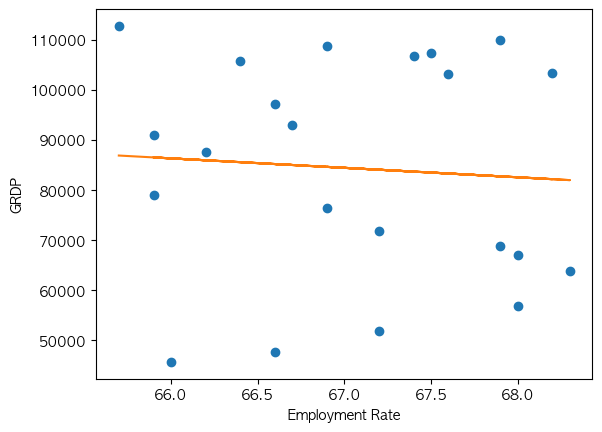

In [252]:
# 회귀선 나타내기
plt.plot(data[s_col], data[p_col], 'o')
plt.plot(data[s_col], data['y_hat'])
plt.ylabel('GRDP')
plt.xlabel('Employment Rate')
plt.show()

In [253]:
'''
회귀분석 툴을 이용하여 값 비교
'''
X = data[s_col].values.reshape(-1,1) # s_col = 'Employment Rate'
y = data[p_col].values.reshape(-1,1) # p_col = 'GRDP'

reg = LinearRegression().fit(X, y)
reg.intercept_, reg.coef_

(array([210936.75883643]), array([[-1887.70962332]]))

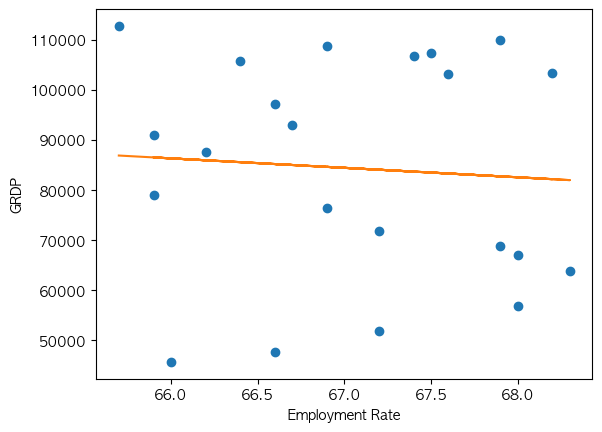

In [254]:
plt.plot(X, y, 'o')
plt.plot(X, reg.predict(X))
plt.ylabel('GRDP')
plt.xlabel('Employment Rate')
plt.show()

In [255]:
'''
회귀분석에 대한 구체적인 결과
'''
from statsmodels.api import OLS
from statsmodels.api import add_constant

X2 = add_constant(X)
est = OLS(y, X2)
est = est.fit()

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.045
Method:                 Least Squares   F-statistic:                   0.09671
Date:                Sun, 04 Jun 2023   Prob (F-statistic):              0.759
Time:                        22:34:29   Log-Likelihood:                -250.92
No. Observations:                  22   AIC:                             505.8
Df Residuals:                      20   BIC:                             508.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.109e+05   4.07e+05      0.518      0.610   -6.38e+05    1.06e+06
x1         -1887.7096   6070.246     -0.311      0.759   -1.46e+04    1.08e+04
==============================================================================
Omnibus:                        3.610   Durbin-Watson:                   0.044
Prob(Omnibus):                  0.164   Jarque-Bera (JB):                1.718
Skew:                          -0.356   Prob(JB):                        0.424
Kurtosis:                       1.831   Cond. No.                     5.62e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""